# Lab Assignment One: Exploring Table Data
Name: Marc Pham, Alonso Gurrola

## 1. Preparation and Overview

### 1.1: Business Understanding

The data, funded by the Instituto Politécnico de Portalegre on April 23, 2021, aims to identify students at risk of dropping out of higher education.  The dataset includes 4,424 students who are classified as dropouts, current enrollees, or graduates.  For each student, the data includes 37 total features, including demographic features (e.g., race and gender) and economic factors (e.g., the inflation rate and unemployment rate at the time of their application) that may influence their likelihood for dropping out.  The funders’ original goal was to use machine learning techniques to detect which students are at risk of dropping out and implement targeted interventions, such as scholarships, to support these students.

The end goal of analyzing this dataset is to classify a student as a potential dropout or an enrollee/graduate based on economic factors and each student’s demographic features.  The results can help university admissions offices and government agencies determine which groups of students need additional support to get through higher education.  However, it is important to note that third parties could use these results to choose which students to accept or deny from a university.  Keeping this in mind, the final classification algorithm should not be trained on race since the Supreme Court banned the use of race in college admissions.  The final model will need to be deployed, so third-parties can keep checking if students are at risk of dropping out as the students go through their first and second semesters. Deploying the model also allows third-parties to determine if a student's risks of dropping out gets worse or better as they continue to go through school.

For the algorithm to be successful, we need the algorithm to accurately classify which students are dropping out.  It is less important if the model inaccurately predicts an Enrollee as a Graduate or vice versa.  As a result, we should use metrics like precision and recall to measure how well the algorithm does at classifying dropouts.  For our algorithm, recall measures the percentage of actual dropouts that the algorithm correctly classifies.  Our recall should be as close as possible to 100% to minimize the probability of missing any students at risk of dropping out.  Precision measures the percentage of students predicted to drop out who are actual dropouts.  Low precision means we are giving additional resources to many students not at risk of dropping out, while high precision means that resources are used effectively.  Although high precision is ideal, it would be acceptable to have lower precision, like 70%, if it significantly increases recall.  The balance between precision and recall will depend on how much financial flexibility institutions have.

Sources: [Dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16

### 1.2: Data Preprocessing

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize_scalar
import copy
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
warnings.filterwarnings('ignore')

In [48]:
df = pd.read_csv('data.csv', sep=';')
df = df.rename(columns = {
    'Daytime/evening attendance\t' : 'Daytime/evening attendance',               
    'Nacionality': 'Nationality'})
df['Target'].replace({'Dropout' : 1, 'Enrolled' : 2, 'Graduate' : 3}, inplace=True);

To determine which of the 37 features should be the most helpful, it is important to determine which features appear to be the most correlated with the target variable. In Lab One, we determined this with a correlation table, which orders the features from those with the strongest correlation (in magnitude) to those with the weakest correlation. A feature with a positive correlation is correlated with a lower chance to drop out; a feature with a negative correlation is correlated with a high chance to drop out.

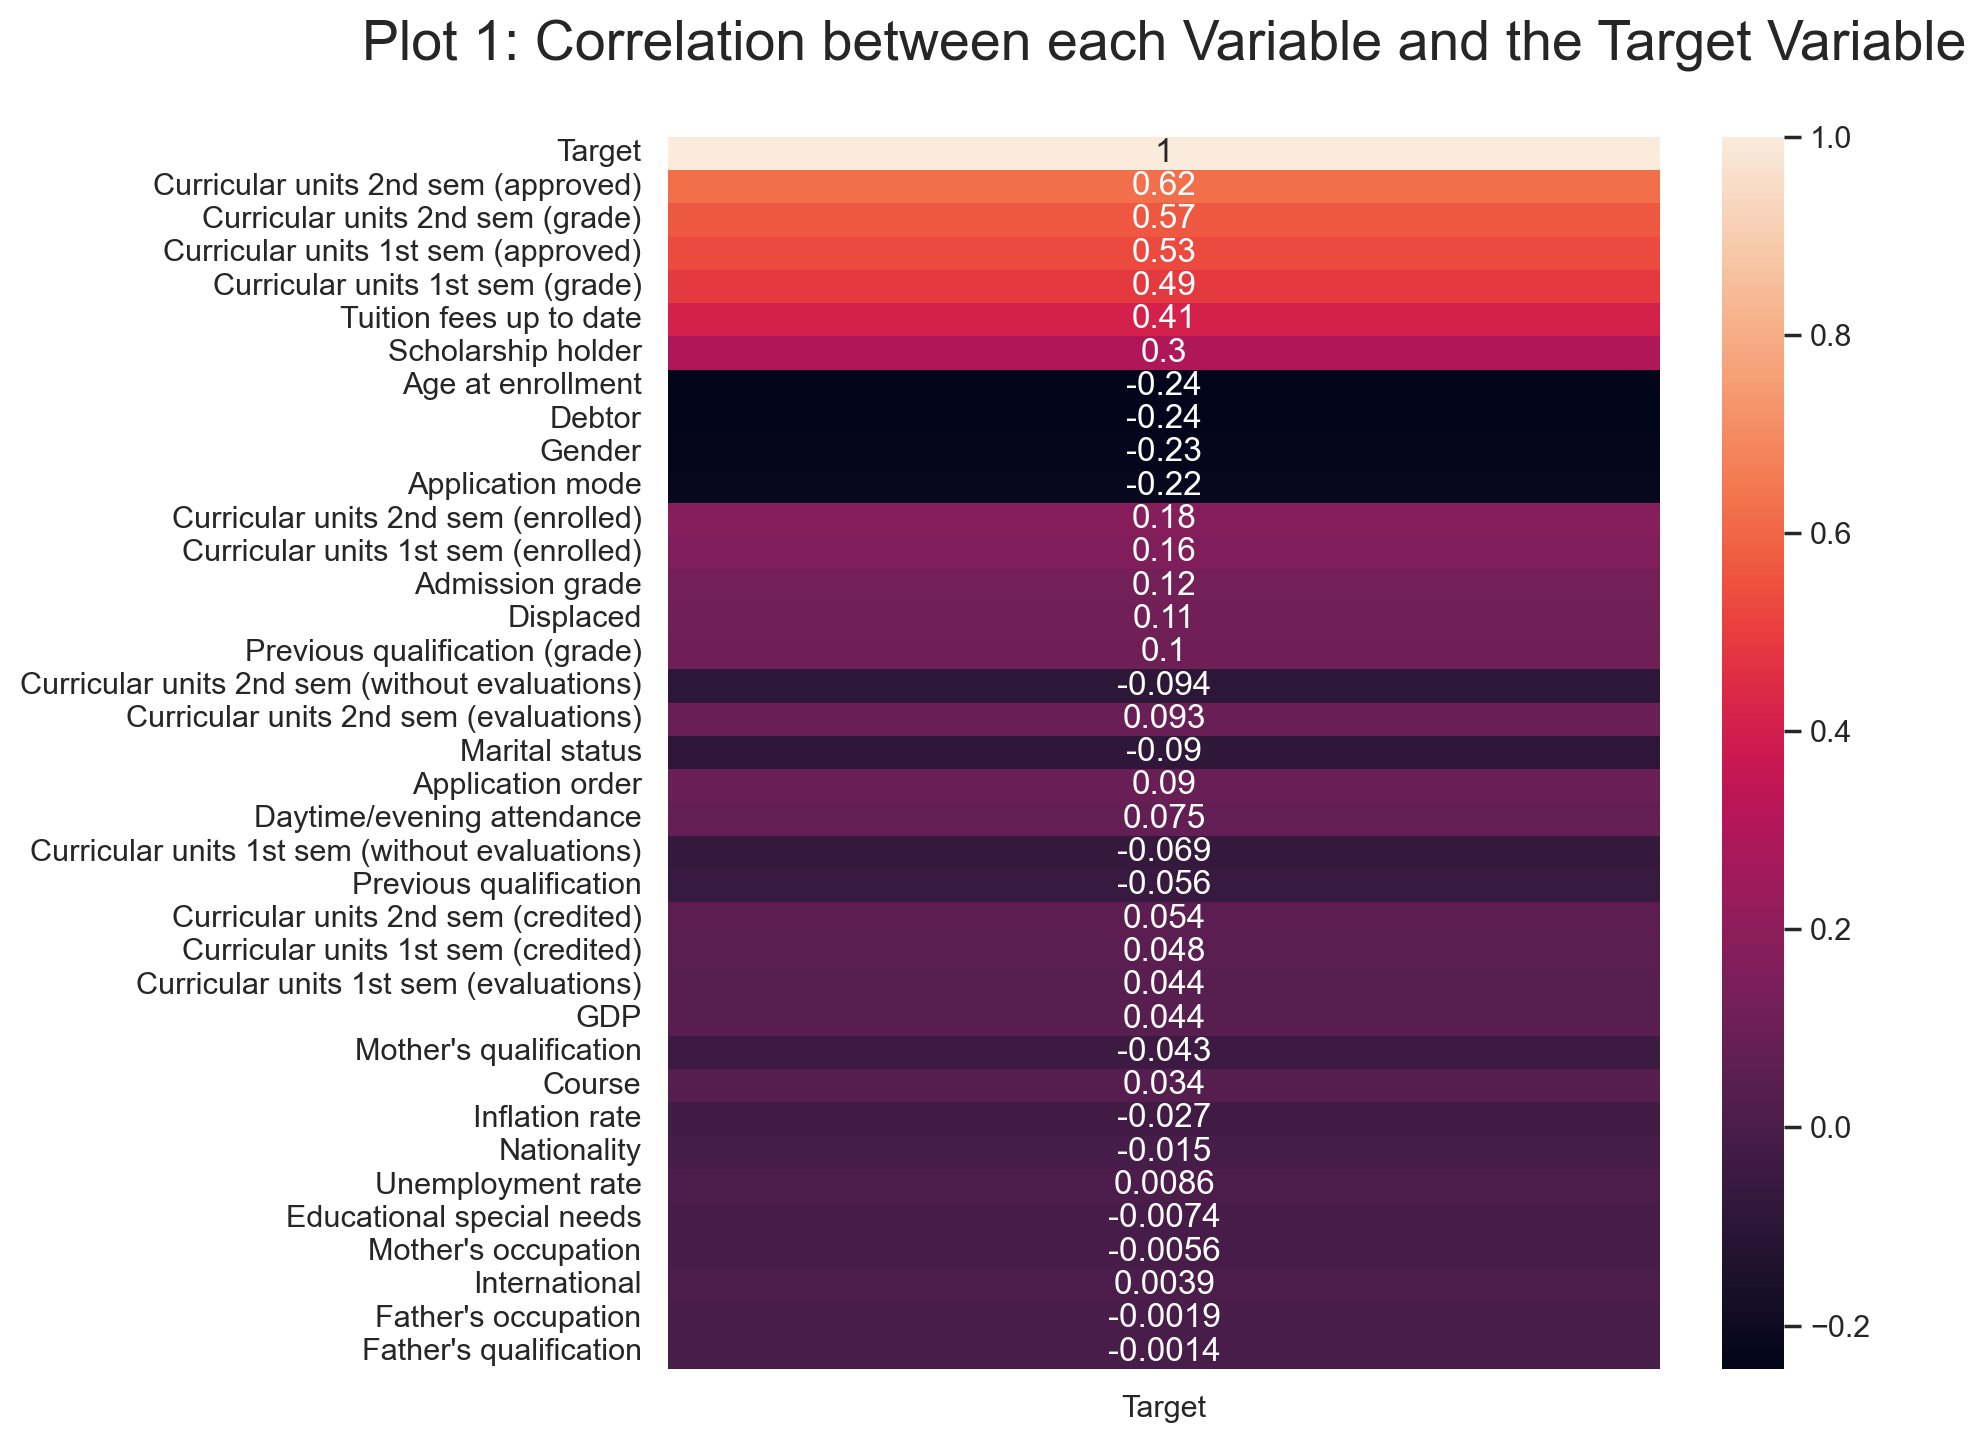

In [49]:
df_target = df.corr()[['Target']]
df_target['abs(Target)'] = df_target['Target'].abs()

cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8), dpi=200)
corrs = pd.DataFrame(df_target.sort_values(by='abs(Target)', ascending=False)['Target'])

# Sort the Correlation Coefficients by its Magnitude but output the raw Correlation Coefficient.
sns.heatmap(corrs, cmap=cmap, annot=True);
ax.set_title("Plot 1: Correlation between each Variable and the Target Variable\n", fontsize=20);


The correlation table indicates that several features are unlikely to help us predict whether or not a student will drop out. In our analysis, we decided to remove all features with a correlation magnitude below 0.1 because keeping them may reduce the model's accuracy by including irrelevant information. This leaves us with 15 features. The only categorical variable with multiple possible values is Application Mode, which we will one-hot encode.


In [69]:
df_less = df[corrs[abs(corrs['Target']) >= 0.1].transpose().columns]
df_less = pd.get_dummies(df_less, prefix='AppMode', columns=['Application mode'], dtype=int)

X = df_less.drop('Target', axis=1)
y = df_less['Target']

**Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).**

In [87]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

pca = PCA(0.90)
X_final = pca.fit_transform(df_scaled)
print(f"Number of PCA Components: {len(X_final[0])}")

Number of PCA Components: 22


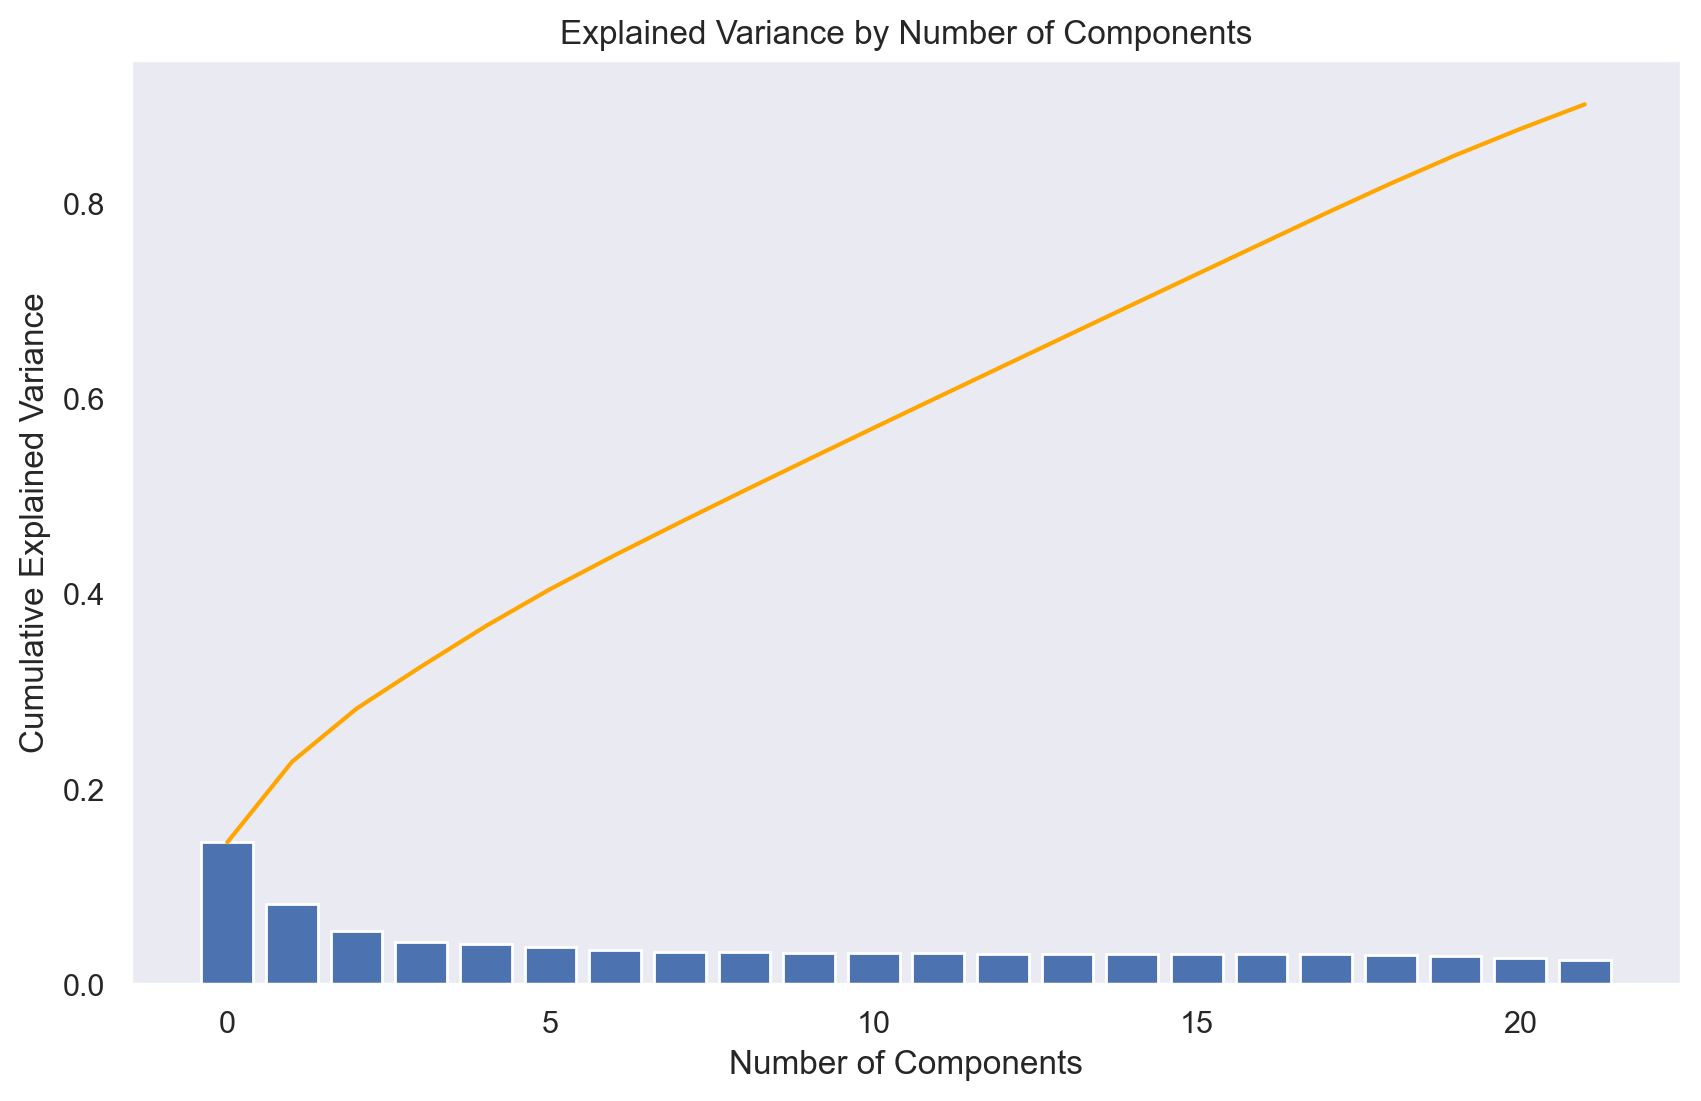

In [90]:
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(np.cumsum(pca.explained_variance_ratio_), c='orange')
plt.bar(np.arange(0, len(X_final[0])), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid()
plt.show()

Upon examining the Explained Variance for different numbers of components, we noticed that there is not a clear point where the cumulative explained variance stabilizes. Therefore, we opted to keep enough components to ensure at least 90% of the variance is explained, which led us to keep 22 PCA components.

### 1.3: Train-Test Split

Applying an 80-20 train-test split is beneficial for our data since it reduces the risk of overfitting the model to the training data. The test set lets us to determine if the model generalizes to unseen data, which gives us valuable insight into how the model will perform when deployed. While one potential drawback of the 80-20 split is that it reduces the amount of data available for training the model, our dataset of 4,424 students is large enough that we still have 3,539 examples to train on after the split.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2)
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

Training Data Shape: (3539, 22), Testing Data Shape: (885, 22)


## 2. Modeling

[2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}. It is recommended to call this the "solver" input for the class.
Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

### *Do Next*: Regularization changes

In [217]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
from numpy.linalg import pinv
from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world

ds = load_iris()
X = ds.data
y = (ds.target>1).astype(int) # make problem binary
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size=0.2, random_state=11)


In [260]:
class BinaryLogisticRegression:

    def __init__(self, eta, iterations=20, C=0.001, solver = "default", line_iters=8):
        self.eta = eta
        self.iters = iterations
        self.C = C

        if solver == "stochastic":
            self._get_gradient = self.stochastic
            self.fit = self.default_fit
        elif solver == "steepest_ascent": 
            # self._get_gradient = self.steepest_ascent
            self.fit = self.fit_steepest
            self.objective_function = self.objective_steepest
            # self.orig_eta = eta
            self.line_iters = line_iters
        elif solver == "newton":
            self._get_gradient = self.newton
            self.fit = self.default_fit
        elif solver == "quasi":
            self.fit = self.fit_bfgs
            self.objective_function = self.objective_quasi
        else:
            self._get_gradient = self.default_gradient
            self.fit = self.default_fit
            
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    """
    All Regularization Functions
    """

    @staticmethod
    def regularization_gradient(w_, C):
        print ((w_[1:] > 0).astype(int))
        return -2 * w_[1:] * C

    @staticmethod
    def regularization_objective(w, C):
        return C*sum(w**2)

    @staticmethod
    def L2_gradient(w_, C):
        return -2 * w_[1:] * C

    @staticmethod
    def L1_gradient(w_, C):
        return -2 * w_[1:] * C

    @staticmethod
    def L2_objective(w, C):
        return C*sum(w**2)

    @staticmethod
    def L1_objective(w, C):
        return C*sum(abs(w))

    """
    Objective Functions
    """

    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_steepest(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + BinaryLogisticRegression.regularization_objective(wnew[1:]**2, C)

    @staticmethod
    def objective_quasi(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + BinaryLogisticRegression.regularization_objective(w, C)
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))
    
    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += BinaryLogisticRegression.regularization_gradient(w, C)
        
        return -gradient
    
    """
    All Gradient Functions
    """
    # vectorized gradient calculation with regularization using L2 Norm
    def default_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += BinaryLogisticRegression.regularization_gradient(self.w_, self.C)
        
        return gradient
    
    def stochastic(self,X,y):
        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)
        
        ydiff = y[idxs]-self.predict_proba(X[idxs],add_bias=False).ravel() # get y difference (now scalar)
        gradient = np.mean(X[idxs] * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += BinaryLogisticRegression.regularization_gradient(self.w_, self.C)
        
        return gradient

    def newton(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += BinaryLogisticRegression.regularization_gradient(self.w_, self.C)
        
        return pinv(hessian) @ gradient
        
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    """
    All Fit Functions
    """
    def default_fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

    def fit_steepest(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self.default_gradient(Xb,y)
            # minimization is in opposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
    
    def fit_bfgs(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))


In [253]:
test = [-0.21209171, -0.472097, -0.52910824, 0.78585247, 0.52051617]
test[test > 0]

TypeError: '>' not supported between instances of 'list' and 'int'

In [261]:
%%time
blr = BinaryLogisticRegression(eta=0.1,iterations=50,C=0.001, solver="default")

blr.fit(X_train,y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

[[0]
 [0]
 [0]
 [0]]
[[0]
 [0]
 [0]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1

In [242]:
%%time
blr = BinaryLogisticRegression(eta=0.01, iterations=300, C=0.001, solver='stochastic') # take a lot more steps!!

blr.fit(X_train,y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.14947728]
 [-0.34564504]
 [-0.41413565]
 [ 0.58938087]
 [ 0.37049267]]
Accuracy of:  1.0
CPU times: user 27.8 ms, sys: 5.12 ms, total: 32.9 ms
Wall time: 31.2 ms


In [243]:
%%time
blr = BinaryLogisticRegression(eta=1.0,
                                    iterations=6, 
                                    line_iters=8, 
                                    C=0.001, solver='steepest_ascent')

blr.fit(X_train,y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-1.05062031]
 [-2.47379803]
 [-3.39282661]
 [ 4.4579333 ]
 [ 2.59667743]]
Accuracy of:  0.9666666666666667
CPU times: user 25.6 ms, sys: 6.09 ms, total: 31.7 ms
Wall time: 28.1 ms


In [244]:
%%time
blr = BinaryLogisticRegression(eta=1.0,
                                      iterations=4,
                                      C=0.001, solver='newton')

blr.fit(X_train,y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-13.16298323]
 [ -1.58430786]
 [  1.17397037]
 [  2.34423557]
 [  4.9845469 ]]
Accuracy of:  0.9333333333333333
CPU times: user 4.81 ms, sys: 3.29 ms, total: 8.1 ms
Wall time: 5.16 ms


In [245]:
%%time
blr = BinaryLogisticRegression(_,iterations=3,C=0.001,solver='quasi')

blr.fit(X_train,y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.20250259]
 [-0.45476932]
 [-0.5999364 ]
 [ 0.85385725]
 [ 0.51590977]]
Accuracy of:  0.9
CPU times: user 7.32 ms, sys: 2.83 ms, total: 10.1 ms
Wall time: 7.9 ms


In [ ]:
# allow for the user to specify the algorithm they want to solver the binary case
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    



In [101]:
class Test:
        
    def __init__(self, bleh):
        if bleh == 'a':
            self.funct = self.first
        else:
            self.funct = self.second

    def first(self):
        print('1')
    def second(self):
        print('2')

In [103]:
tre = Test('3')
tre.funct()

2
